# Novozymes Enzyme Stability Prediction - Random Forest Regressor Approach

# House Keeping

In [1]:
# import libraries

import numpy as np # linear algebra stuff
import pandas as pd # data processing stuff
import seaborn as sns # plot fancy stuff
import matplotlib.pyplot as plt # plot stuff
import re # RegEx to find stuff
from IPython.display import FileLink # add stuff to file
import os # operating stuff

from sklearn.ensemble import RandomForestRegressor # model to predict stuff
from sklearn.model_selection import train_test_split # splitting stuff into more stuff
from sklearn.model_selection import RandomizedSearchCV # check random stuff 
from sklearn import metrics # check stats on stuff

from scipy import stats # stats on stuff
from scipy.stats import randint # random stuff
from scipy.stats import spearmanr # coefficient of stuff

ModuleNotFoundError: No module named 'numpy.lib._datasource'

In [3]:
# list files in cd

print('Files in currenct directory:\n')
for dirname, _, filenames in os.walk('.'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

Files in currenct directory:

.\jointplot.png
.\Novozymes_Kaggle_Model.ipynb
.\README.md
.\sample_submission.csv
.\test.csv
.\train.csv
.\train_updates_20220929.csv
.\wildtype_structure_prediction_af2.pdb
.\.ipynb_checkpoints\enzyme-stability-prediction-rand-forest-approch-checkpoint.ipynb
.\.ipynb_checkpoints\Novozymes_Kaggle_Model-checkpoint.ipynb
.\.ipynb_checkpoints\sample_submission-checkpoint.csv
.\.ipynb_checkpoints\wildtype_structure_prediction_af2-checkpoint.pdb


In [55]:
# Load traning set
train = pd.read_csv('train.csv')
print(f'Loaded the training dataset with the size {train.shape} and columns {[train.columns[n] for n in range(len(train.columns))]}')


# Load updates to the training set
train_update = pd.read_csv('train_updates_20220929.csv')
print(f'\nLoaded the updates to the training dataset with the size {train_update.shape} and columns {[train_update.columns[n] for n in range(len(train_update.columns))]}')

# Load test set 
test = pd.read_csv('test.csv')
print(f'\nLoaded the test dataset with the size {test.shape} and columns {[test.columns[n] for n in range(len(test.columns))]}')

Loaded the training dataset with the size (31390, 5) and columns ['seq_id', 'protein_sequence', 'pH', 'data_source', 'tm']

Loaded the updates to the training dataset with the size (2434, 5) and columns ['seq_id', 'protein_sequence', 'pH', 'data_source', 'tm']

Loaded the test dataset with the size (2413, 4) and columns ['seq_id', 'protein_sequence', 'pH', 'data_source']


# Exploratory Data Analysis

In [5]:
train.head()

,seq_id,protein_sequence,pH,data_source,tm
0,0,AAAAKAAALALLGEAPEVVDIWLPAGWRQPFRVFRLERKGDGVLVG...,7.0,doi.org/10.1038/s41592-020-0801-4,75.7
1,1,AAADGEPLHNEEERAGAGQVGRSLPQESEEQRTGSRPRRRRDLGSR...,7.0,doi.org/10.1038/s41592-020-0801-4,50.5
2,2,AAAFSTPRATSYRILSSAGSGSTRADAPQVRRLHTTRDLLAKDYYA...,7.0,doi.org/10.1038/s41592-020-0801-4,40.5
3,3,AAASGLRTAIPAQPLRHLLQPAPRPCLRPFGLLSVRAGSARRSGLL...,7.0,doi.org/10.1038/s41592-020-0801-4,47.2
4,4,AAATKSGPRRQSQGASVRTFTPFYFLVEPVDTLSVRGSSVILNCSA...,7.0,doi.org/10.1038/s41592-020-0801-4,49.5


In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31390 entries, 0 to 31389
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   seq_id            31390 non-null  int64  
 1   protein_sequence  31390 non-null  object 
 2   pH                31104 non-null  float64
 3   data_source       28043 non-null  object 
 4   tm                31390 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 1.2+ MB


In [7]:
train.describe()

,seq_id,pH,tm
count,31390.000000,31104.000000,31390.000000
mean,15694.500000,6.892339,49.147337
std,9061.656811,1.612225,14.010089
min,0.000000,1.990000,-1.000000
25%,7847.250000,7.000000,42.100000
50%,15694.500000,7.000000,48.000000
75%,23541.750000,7.000000,53.800000
max,31389.000000,64.900000,130.000000


In [79]:
# corelation matrix of numerical values

(train[[
    'seq_id', 
    'pH', 
    'tm',]]
    .corr())

,seq_id,pH,tm
seq_id,1.000000,-0.039884,0.00875
pH,-0.039884,1.000000,-0.04445
tm,0.008750,-0.044450,1.00000


In [21]:
# Data source is not needed for the remaining analysis

train = train.drop(['data_source'], 
                    axis=1
                    )
train

,seq_id,protein_sequence,pH,tm
0,0,AAAAKAAALALLGEAPEVVDIWLPAGWRQPFRVFRLERKGDGVLVG...,7.0,75.7
1,1,AAADGEPLHNEEERAGAGQVGRSLPQESEEQRTGSRPRRRRDLGSR...,7.0,50.5
2,2,AAAFSTPRATSYRILSSAGSGSTRADAPQVRRLHTTRDLLAKDYYA...,7.0,40.5
3,3,AAASGLRTAIPAQPLRHLLQPAPRPCLRPFGLLSVRAGSARRSGLL...,7.0,47.2
4,4,AAATKSGPRRQSQGASVRTFTPFYFLVEPVDTLSVRGSSVILNCSA...,7.0,49.5
...,...,...,...,...
31385,31385,YYMYSGGGSALAAGGGGAGRKGDWNDIDSIKKKDLHHSRGDEKAQG...,7.0,51.8
31386,31386,YYNDQHRLSSYSVETAMFLSWERAIVKPGAMFKKAVIGFNCNVDLI...,7.0,37.2
31387,31387,YYQRTLGAELLYKISFGEMPKSAQDSAENCPSGMQFPDTAIAHANV...,7.0,64.6
31388,31388,YYSFSDNITTVFLSRQAIDDDHSLSLGTISDVVESENGVVAADDAR...,7.0,50.7


# Data Cleaning

In [56]:
# Find and replace null values with mean value

print(f'Shape of the training data before ourlier removal:\n{train.isnull().sum()}')

train['pH'] = (train['pH']
              .fillna(train['pH']
              .mean()))

print(f'\nShape of the training data after ourlier removal:\n{train.isnull().sum()}')

Shape of the training data before ourlier removal:
seq_id                 0
protein_sequence       0
pH                   286
data_source         3347
tm                     0
dtype: int64

Shape of the training data after ourlier removal:
seq_id                 0
protein_sequence       0
pH                     0
data_source         3347
tm                     0
dtype: int64


In [24]:
# Remove any pH value below 0 and above 14

print(f'Shape of the training data before ourlier removal: {train.shape}')

row_before, col_before = train.shape

train = train[train['pH'] <= 14]

print(f'\nShape of the training data after ourlier removal: {train.shape}')

row_after, col_after = train.shape

print(f'\nRows removed: {row_before - row_after}, Columns removed: {col_before - col_after}')

Shape of the training data before ourlier removal: (31390, 23)

Shape of the training data after ourlier removal: (31075, 23)

Rows removed: 315, Columns removed: 0


In [1]:
# Heatmap of correlation matrix for training data columns

sns.heatmap((train[[
            'seq_id', 
            'pH', 
            'tm',
            ]].corr()),
            linewidths=1,
            cmap=plt.cm.Reds, 
            annot=True)

plt.title('Heatmap for correlation between columns of training data')

NameError: name 'sns' is not defined

# Feature Engineering

In [22]:
# Replace sequence with count of individual amino acids

search_amino = ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y']
for amino_acid in search_amino:
     train[amino_acid] = (train['protein_sequence']
                          .str
                          .count(amino_acid,re.I))
        
train = train.drop(['protein_sequence'], 
                   axis=1)
train

,seq_id,pH,tm,A,C,D,E,F,G,H,...,M,N,P,Q,R,S,T,V,W,Y
0,0,7.0,75.7,45,1,13,30,13,38,3,...,8,5,18,6,25,11,14,37,4,3
1,1,7.0,50.5,28,0,10,52,6,18,4,...,2,6,8,22,30,14,12,13,3,3
2,2,7.0,40.5,50,9,27,32,21,65,11,...,6,15,20,25,31,33,30,30,3,16
3,3,7.0,47.2,20,5,19,29,12,16,7,...,2,9,16,9,10,16,19,14,3,4
4,4,7.0,49.5,86,14,78,78,32,84,40,...,31,65,128,54,63,148,120,124,16,47
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31385,31385,7.0,51.8,33,12,38,31,18,51,15,...,13,24,25,24,42,33,18,42,13,18
31386,31386,7.0,37.2,37,5,21,29,22,27,22,...,14,19,19,16,25,37,26,34,5,14
31387,31387,7.0,64.6,13,1,7,7,7,11,2,...,7,5,6,8,3,10,6,7,4,4
31388,31388,7.0,50.7,47,5,34,36,23,52,11,...,26,25,31,12,25,51,32,48,3,18


In [ ]:
test.describe()

,seq_id,pH
count,2413.000000,2413.0
mean,32596.000000,8.0
std,696.717422,0.0
min,31390.000000,8.0
25%,31993.000000,8.0
50%,32596.000000,8.0
75%,33199.000000,8.0
max,33802.000000,8.0


In [ ]:
# Replace sequence with count of individual amino acids in the test set and drop unused columns

test = test.drop(['data_source'],
          axis=1,)

for amino in search_amino:
    test[amino]=test['protein_sequence'].str.count(amino,re.I)

test = test.drop(['protein_sequence'],
          axis=1,)

test.head()

,seq_id,pH,A,C,D,E,F,G,H,I,...,M,N,P,Q,R,S,T,V,W,Y
0,31390,8,22,4,15,8,10,19,0,6,...,0,19,17,13,3,18,8,13,6,6
1,31391,8,22,4,15,7,10,19,0,6,...,0,19,17,13,3,18,8,13,6,6
2,31392,8,22,4,15,7,10,19,0,6,...,0,19,17,13,3,18,8,13,6,6
3,31393,8,22,5,15,7,10,19,0,6,...,0,19,17,13,3,18,8,13,6,6
4,31394,8,22,4,15,7,11,19,0,6,...,0,19,17,13,3,18,8,13,6,6


# Data Visualization of training data

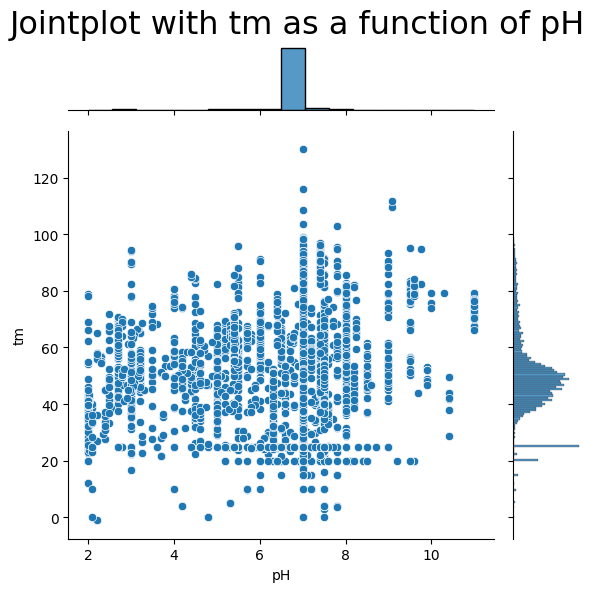

In [41]:
p = sns.jointplot(data = train,
              x = "pH",
              y = "tm")


p.fig.suptitle("Jointplot with tm as a function of pH", fontsize = 23)
p.fig.tight_layout()
p.fig.subplots_adjust(top = 0.92) # Reduce plot to make room

# Model Training

In [82]:
# Split data in features and labels (tm)

X = train.drop(['tm'],axis=1)
y = train['tm']

print(f'Dataset shape before splitting: \nTrain dataset features: {X.shape} \nTrain dataset labels: {y.shape}')

X_train, X_valid, y_train, y_valid = train_test_split(X,
                                                      y,
                                                      test_size = 0.20,
                                                      random_state = 42
                                                     )

(print(f'\nDataset shape after splitting: \nX_train: {X_train.shape} \nX_valid: {X_valid.shape} \ny_train: {y_train.shape} \ny_valid: {y_valid.shape}'))

Dataset shape before splitting: 
Train dataset features: (31390, 4) 
Train dataset labels: (31390,)

Dataset shape after splitting: 
X_train: (25112, 4) 
X_valid: (6278, 4) 
y_train: (25112,) 
y_valid: (6278,)


In [74]:
# Instanciate the model and show its parameters

rf = RandomForestRegressor()

for i in rf.get_params():
    print(f'{i}: {rf.get_params()[i]}')

bootstrap: True
ccp_alpha: 0.0
criterion: squared_error
max_depth: None
max_features: 1.0
max_leaf_nodes: None
max_samples: None
min_impurity_decrease: 0.0
min_samples_leaf: 1
min_samples_split: 2
min_weight_fraction_leaf: 0.0
n_estimators: 100
n_jobs: None
oob_score: False
random_state: None
verbose: 0
warm_start: False


In [ ]:
# Create a random_grid to tune hyperparameters

random_grid={'max_depth':list(np.arange(10, 100, step=10)),
              'n_estimators':np.arange(10, 500, step=50),
              'max_features':randint(1,7),
              'min_samples_leaf':randint(1,4),
              'min_samples_split':np.arange(2, 10, step=2)
             }

In [58]:
# Use the random grid to search for best hyperparameters
# Create the base model to tune

rf = RandomForestRegressor(random_state = 42)

# Random search of parameters, using 3 fold cross validation

rf_random = RandomizedSearchCV(estimator=rf, 
                               param_distributions=random_grid,
                               n_iter=10, 
                               scoring='neg_mean_absolute_error', 
                               cv=3, 
                               verbose=2, 
                               random_state=42, 
                               n_jobs=-1,
                               return_train_score=True
                              )

# Fit the random search model

rf_random.fit(X_train, y_train)

NameError: name 'random_grid' is not defined

# Model Prediction

In [ ]:
y_predict= rf_random.predict(X_valid)
y_predict.shape

In [ ]:
test.shape

In [57]:
# Density Plot and Histogram of all arrival delays
sns.displot(y_valid, 
            hist=True, 
            kde=True, 
            bins=int(180/5), 
            color='darkblue', 
            hist_kws={'edgecolor':'black'},
            kde_kws={'linewidth': 4}
           )

# Density Plot and Histogram of all arrival delays
sns.displot(y_predict, 
            hist=True, 
            kde=True, 
            bins=int(180/5), 
            color='red', 
            hist_kws={'edgecolor':'green'},
            kde_kws={'linewidth': 4})


NameError: name 'y_valid' is not defined

In [ ]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_valid, y_predict))
print('Mean Squared Error:', metrics.mean_squared_error(y_valid, y_predict))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_valid, y_predict)))

In [ ]:
stats.spearmanr(y_valid, y_predict)

In [ ]:
submission = pd.DataFrame()

In [ ]:
submission['seq_id'] = test['seq_id']

In [ ]:
submission['tm'] = rf_random.predict(test)

In [ ]:
submission.to_csv('submission.csv',index=False)
submission

In [ ]:
FileLink(r'submission.csv')